In [1]:
import re
import nltk
import emoji
import string
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from PIL import Image
from collections import Counter
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, Attention
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\heman\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\heman\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
tweets_df  = pd.read_csv('cyberbullying_tweets.csv')

In [4]:
tweets_df .rename(columns={'tweet_text': 'text', 'cyberbullying_type': 'sentiment'}, inplace=True)
tweets_df .drop_duplicates(subset="text", inplace=True)

In [5]:
tweets_df [:5]

,text,sentiment
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [6]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46017 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       46017 non-null  object
 1   sentiment  46017 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [7]:
tweets_df.head()

,text,sentiment
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [8]:
tweets_df.size

92034

In [9]:
tweets_df.sentiment.value_counts()

sentiment
religion               7995
age                    7992
ethnicity              7952
not_cyberbullying      7937
gender                 7898
other_cyberbullying    6243
Name: count, dtype: int64

In [10]:
tweets_df.isnull().sum()

text         0
sentiment    0
dtype: int64

In [11]:
tweets_df["encode"] = tweets_df["sentiment"].replace({"religion": 1, 
                                                    "age": 2, 
                                                    "ethnicity": 3,
                                                    "gender": 4, 
                                                    "other_cyberbullying": 5,
                                                    "not_cyberbullying": 6})

In [12]:
tweets_df[:5]

,text,sentiment,encode
0,"In other words #katandandre, your food was cra...",not_cyberbullying,6
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,6
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,6
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,6
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,6


In [13]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  
                           u"\U0001F300-\U0001F5FF" 
                           u"\U0001F680-\U0001F6FF"  
                           u"\U0001F1E0-\U0001F1FF"  
                           u"\U0001F1F2-\U0001F1F4"  
                           u"\U0001F1E6-\U0001F1FF"  
                           u"\U0001F600-\U0001F64F"
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\U0001F910-\U0001F974"
                           u"\U0001F975-\U0001F976"
                           u"\U0001F97A"
                           u"\U0001F9A0"
                           u"\U0001F9A5"
                           u"\U0001F9B0-\U0001F9B9"
                           u"\U0001F9C0-\U0001F9C2"
                           u"\U0001F9D0-\U0001F9FF"
                           u"\U0001FA00-\U0001FA6F"
                           u"\U0001FA70-\U0001FAFF"
                           u"\U00002702-\U000027B0"
                           u"\U0001F1E6-\U0001F1FF"  
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').lower()
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)
    text = re.sub(r'[^\x00-\x7f]',r'', text)
    text = re.sub(r'(.)1+', r'1', text)
    text = re.sub('[0-9]+', '', text)
    stopchars= string.punctuation
    table = str.maketrans('', '', stopchars)
    text = text.translate(table)
    text = [word for word in text.split() if word not in stop_words]
    text = ' '.join(text)
    return text

def decontract(text):
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

def clean_hashtags(text):
    new_text = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', text))
    new_text2 = " ".join(word.strip() for word in re.split('#|_', new_text))
    return new_text2

def filter_chars(text):
    sent = []
    for word in text.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text):
    return re.sub("\s\s+" , " ", text)

def stemmer(text):
    tokenized = nltk.word_tokenize(text)
    ps = PorterStemmer()
    return ' '.join([ps.stem(words) for words in tokenized])

def lemmatize(text):
    tokenized = nltk.word_tokenize(text)
    lm = WordNetLemmatizer()
    return ' '.join([lm.lemmatize(words) for words in tokenized])

In [14]:
def preprocess(text):
    text = remove_emoji(text)
    text = decontract(text)
    text = strip_all_entities(text)
    text = clean_hashtags(text)
    text = filter_chars(text)
    text = remove_mult_spaces(text)
    text = stemmer(text)
    text = lemmatize(text)
    return text

In [15]:
tweets_df['cleaned_text'] = tweets_df['text'].apply(preprocess)

In [16]:
tweets_df.head()

,text,sentiment,encode,cleaned_text
0,"In other words #katandandre, your food was cra...",not_cyberbullying,6,word katandandr food crapilici mkr
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,6,aussietv white mkr theblock imacelebrityau tod...
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,6,classi whore red velvet cupcak
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,6,meh p thank head concern anoth angri dude twitter
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,6,isi account pretend kurdish account like islam...


In [17]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [18]:
# tokenize text data
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(tweets_df['cleaned_text'])
sequences = tokenizer.texts_to_sequences(tweets_df['cleaned_text'])
padded_sequences = pad_sequences(sequences, padding='post')

In [19]:
train_texts, test_texts, train_labels, test_labels = train_test_split( tweets_df['cleaned_text'], 
                                                                       tweets_df['encode'], 
                                                                       test_size=0.2, 
                                                                       random_state=0
                                                                    )

In [20]:
(train_texts.shape, train_labels.shape), (test_texts.shape, test_labels.shape)

(((36813,), (36813,)), ((9204,), (9204,)))

In [21]:
tokenizer = Tokenizer(num_words=10000) 
tokenizer.fit_on_texts(train_texts)

# texts to sequences
train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

# pad the sequences to ensure uniform length
train_padded = pad_sequences(train_sequences, maxlen=100)  
test_padded = pad_sequences(test_sequences, maxlen=100)


In [22]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=10000, output_dim=16, input_length=100),  
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')  
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [23]:
train_labels = train_labels - 1
test_labels = test_labels - 1

In [24]:
history = model.fit(train_padded, train_labels, epochs=50, validation_data=(test_padded, test_labels))

Epoch 1/50
1151/1151 [==============================] - 5s 4ms/step - loss: 1.2632 - accuracy: 0.5879 - val_loss: 0.6663 - val_accuracy: 0.7651
Epoch 2/50
1151/1151 [==============================] - 4s 4ms/step - loss: 0.5464 - accuracy: 0.7822 - val_loss: 0.4851 - val_accuracy: 0.7893
Epoch 3/50
1151/1151 [==============================] - 4s 4ms/step - loss: 0.4592 - accuracy: 0.8002 - val_loss: 0.4537 - val_accuracy: 0.8049
Epoch 4/50
1151/1151 [==============================] - 4s 4ms/step - loss: 0.4279 - accuracy: 0.8139 - val_loss: 0.4488 - val_accuracy: 0.8055
Epoch 5/50
1151/1151 [==============================] - 4s 4ms/step - loss: 0.4081 - accuracy: 0.8248 - val_loss: 0.4406 - val_accuracy: 0.8071
Epoch 6/50
1151/1151 [==============================] - 4s 4ms/step - loss: 0.3910 - accuracy: 0.8352 - val_loss: 0.4355 - val_accuracy: 0.8106
Epoch 7/50
1151/1151 [==============================] - 4s 4ms/step - loss: 0.3770 - accuracy: 0.8431 - val_loss: 0.4353 - val_accuracy:

In [25]:
test_loss, test_acc = model.evaluate(test_padded, test_labels)
print('Test Accuracy:', test_acc)

288/288 [==============================] - 0s 1ms/step - loss: 0.8784 - accuracy: 0.7935
Test Accuracy: 0.7934593558311462


In [26]:
y_pred = model.predict(test_padded)

288/288 [==============================] - 0s 1ms/step


In [27]:
y_pred[:1]

array([[9.9999595e-01, 1.9823089e-20, 4.0064501e-06, 9.0763938e-11,
        1.5350658e-08, 3.9378203e-09]], dtype=float32)

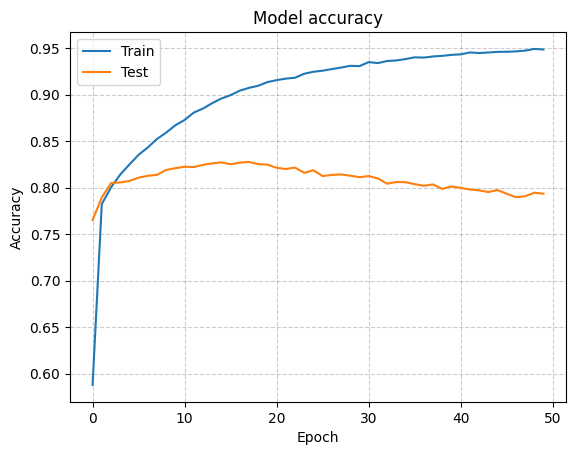

In [28]:
# training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.grid(True, ls='--', alpha=0.2, color='black')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

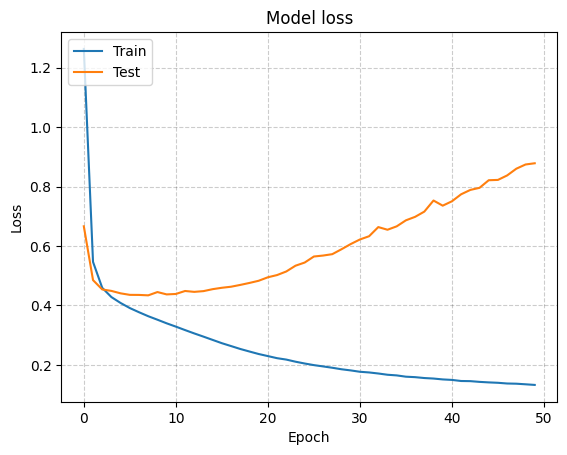

In [29]:
# training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid(True, ls='--', alpha=0.2, color='black')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

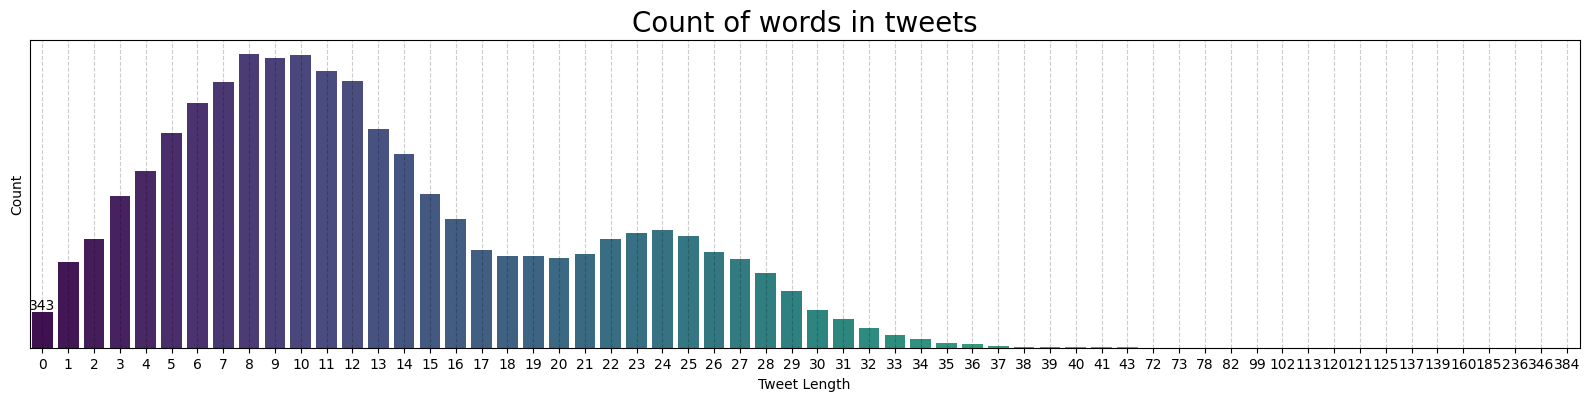

In [30]:
# length of each preprocessed tweet
text_len = [len(text.split()) for text in tweets_df['cleaned_text']]  
tweets_df['text_len'] = text_len

plt.figure(figsize=(20,4))
ax = sns.countplot(x='text_len', data=tweets_df, palette='viridis')
plt.title('Count of words in tweets', fontsize=20)
plt.grid(True, ls='--', alpha=0.2, color='black')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('Count')
plt.xlabel('Tweet Length')
plt.show()

In [31]:
def plot_wordcloud(cyberbullying_type, dataframe):
    string = " ".join(dataframe[dataframe['sentiment'] == cyberbullying_type]['cleaned_text'].values)
    wordcloud = WordCloud(background_color='white', max_words=2000, max_font_size=256, random_state=42, min_font_size=10,).generate(string)
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.title(cyberbullying_type)
    plt.show()

In [32]:
not_cyberbullying_type = tweets_df[tweets_df['sentiment'] == 'not_cyberbullying']
gender_type = tweets_df[tweets_df['sentiment'] == 'gender']
religion_type = tweets_df[tweets_df['sentiment'] == 'religion']
other_cyberbullying_type = tweets_df[tweets_df['sentiment'] == 'other_cyberbullying']
age_type = tweets_df[tweets_df['sentiment'] == 'age']
ethnicity_type = tweets_df[tweets_df['sentiment'] == 'ethnicity']

In [33]:
def analyse_sentiment_category(sentiment_category, tweets_df):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    # wordCloud for the sentiment 
    generate_wordcloud(sentiment_category, tweets_df, ax1)
    # top 20 words in the sentiment category
    sentiment_data = tweets_df[tweets_df['sentiment'] == sentiment_category]
    top20_words = Counter([word for text in sentiment_data['cleaned_text'] for word in text.split()]).most_common(20)
    top20_words_df = pd.DataFrame(top20_words, columns=['Top Words', 'Count'])
    #top 20 words 
    sns.barplot(data=top20_words_df, x='Count', y='Top Words', palette='viridis', ax=ax2)
    ax2.set_title(f"Top 20 Words in '{sentiment_category}' Cyberbullying")
    ax2.set_xlabel('Count')
    ax2.set_ylabel('Top Words')
    plt.grid(True, ls='--', alpha=0.3, color='gray')
    plt.tight_layout()
    plt.show()
    print("\n")

# function to generate WordCloud
def generate_wordcloud(sentiment_category, tweets_df, ax):
    string = ""
    for i in tweets_df[tweets_df.sentiment == sentiment_category].cleaned_text.values:
        string = string + " " + i.strip()
    wordcloud = WordCloud(background_color ='white', max_words=2000, max_font_size=256,
               random_state=42, width=800, height=400, min_font_size=10).generate(string)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")
    ax.set_title(sentiment_category)

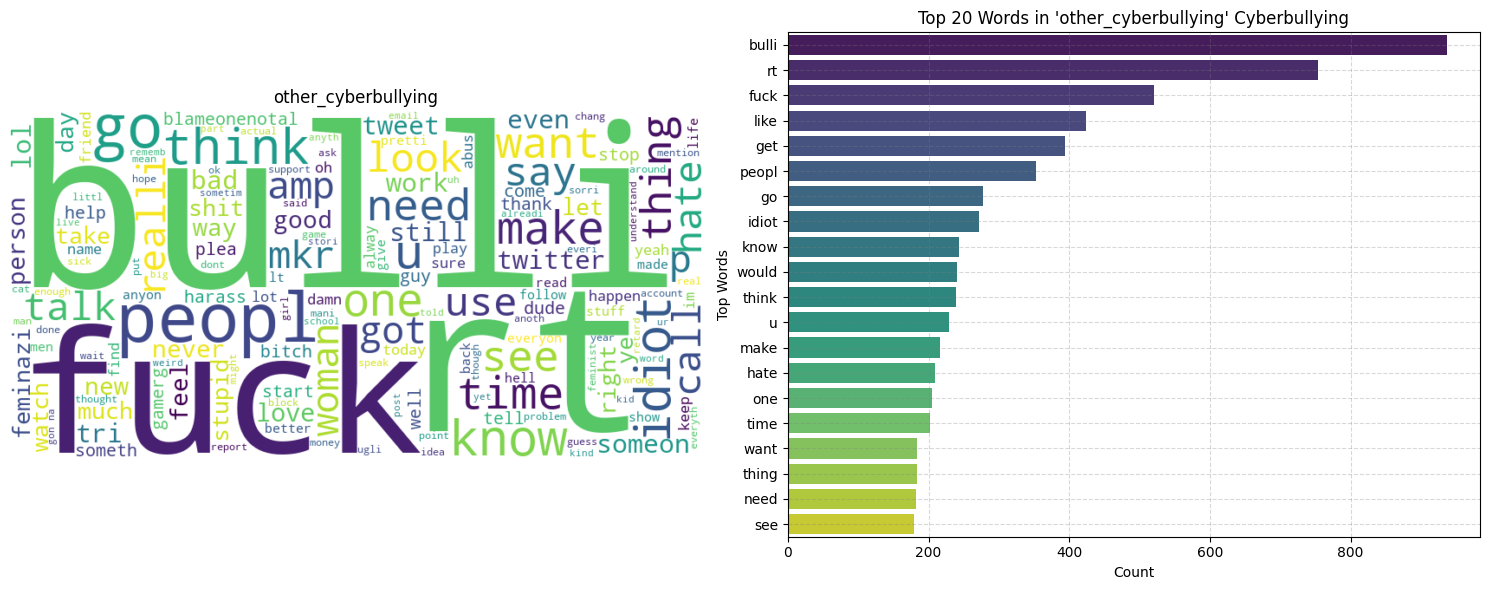

In [34]:
analyse_sentiment_category('other_cyberbullying', tweets_df)

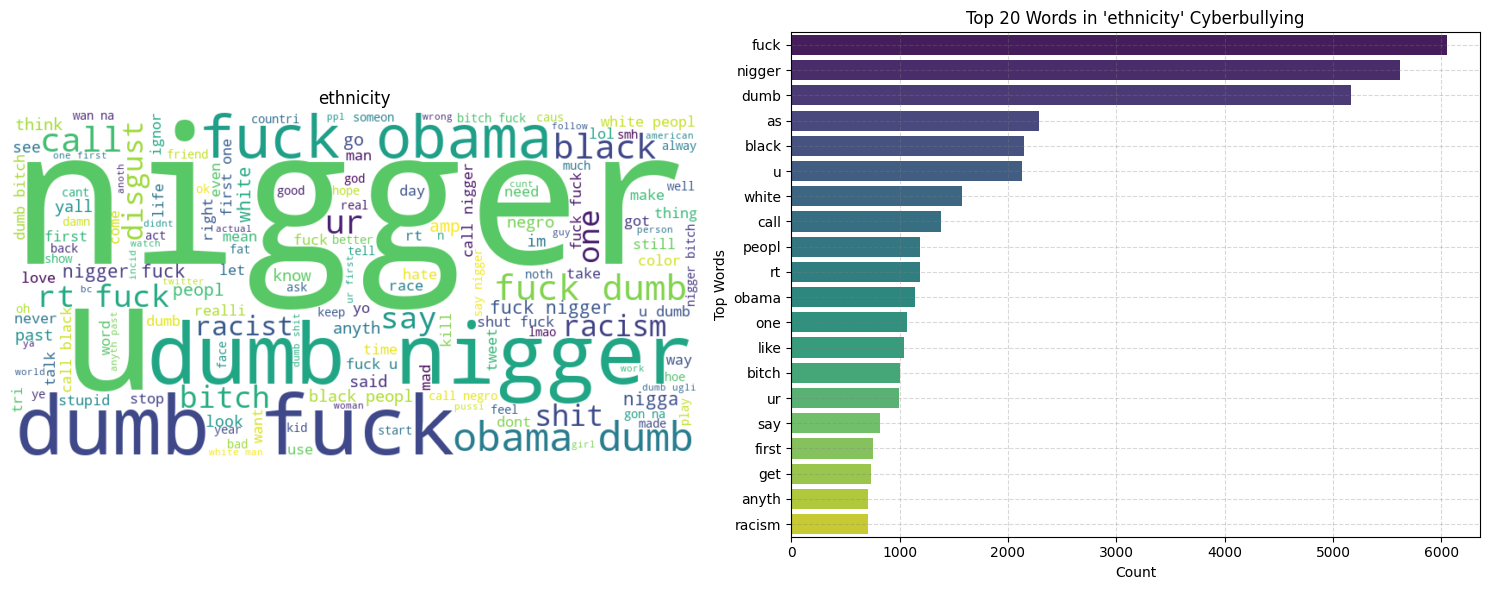

In [35]:
analyse_sentiment_category('ethnicity', tweets_df)

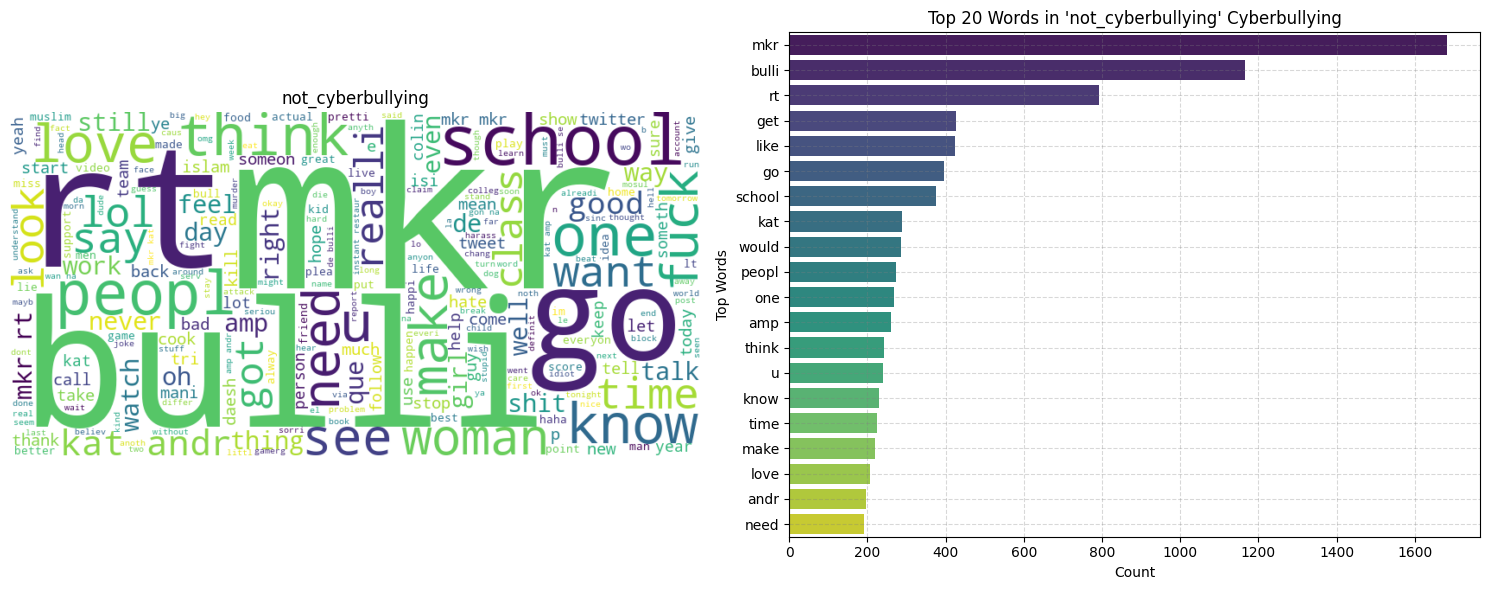

In [36]:
analyse_sentiment_category('not_cyberbullying', tweets_df)

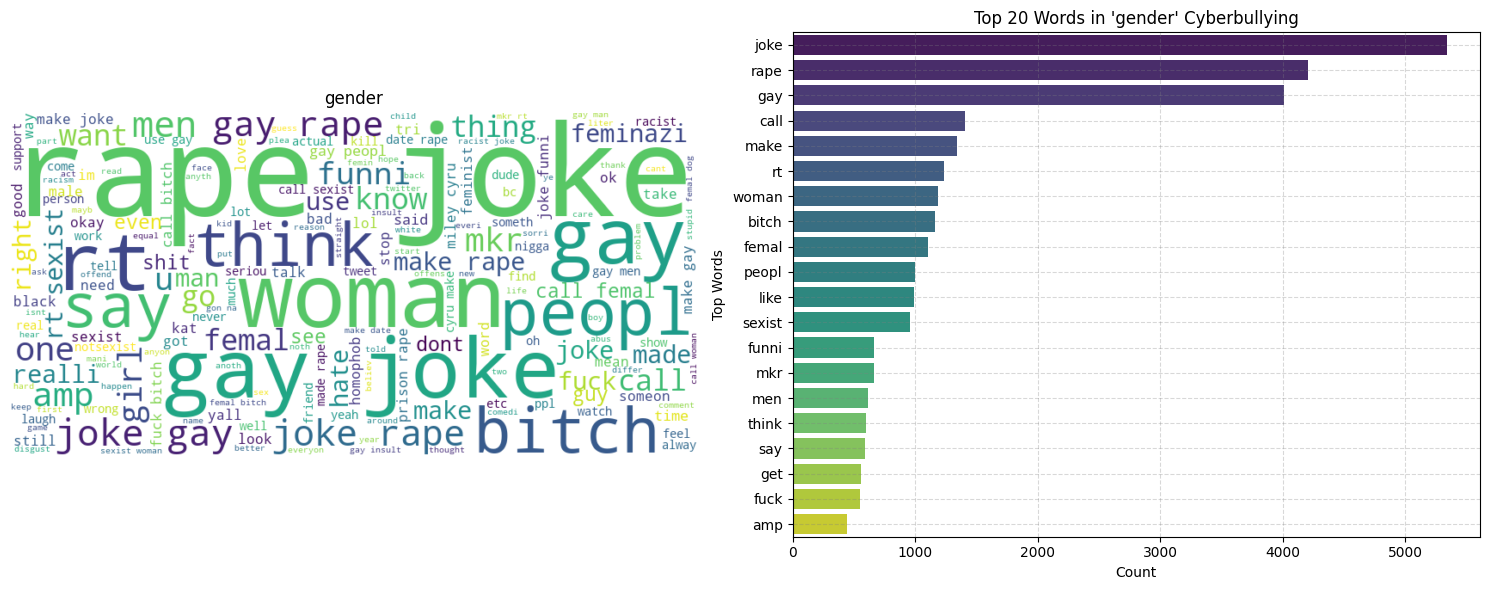

In [37]:
analyse_sentiment_category('gender', tweets_df)

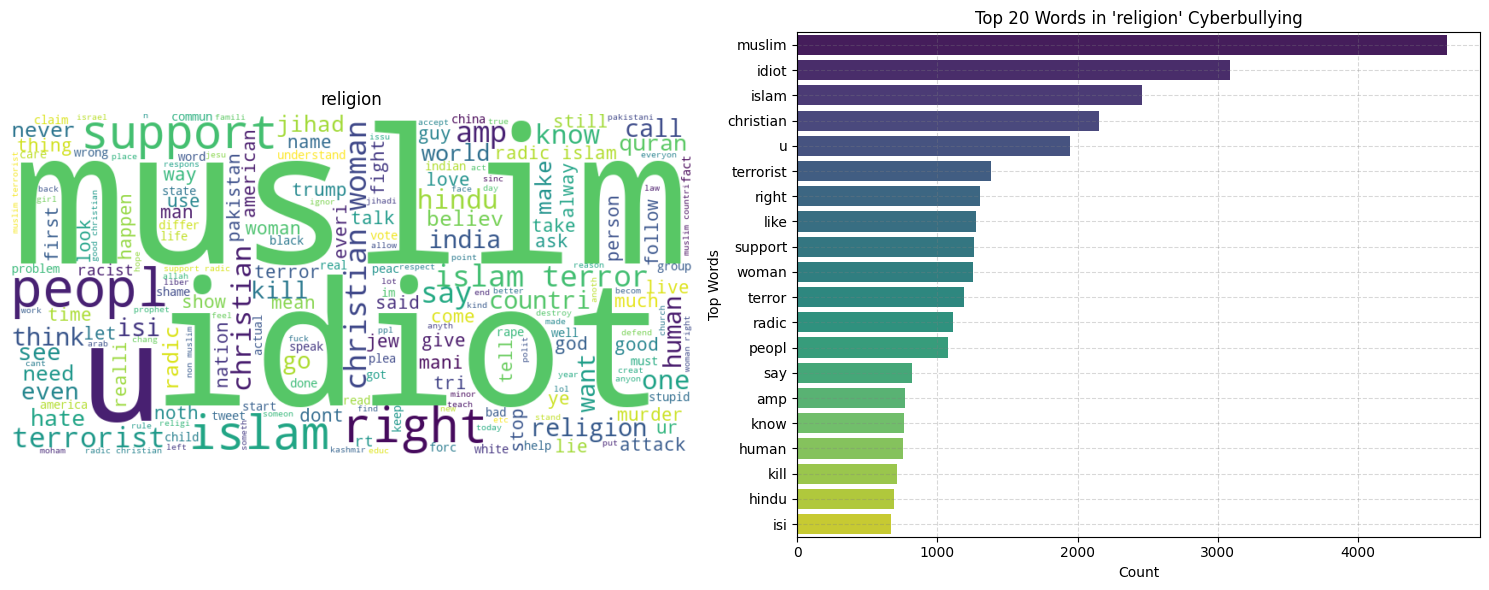

In [38]:
analyse_sentiment_category('religion', tweets_df)

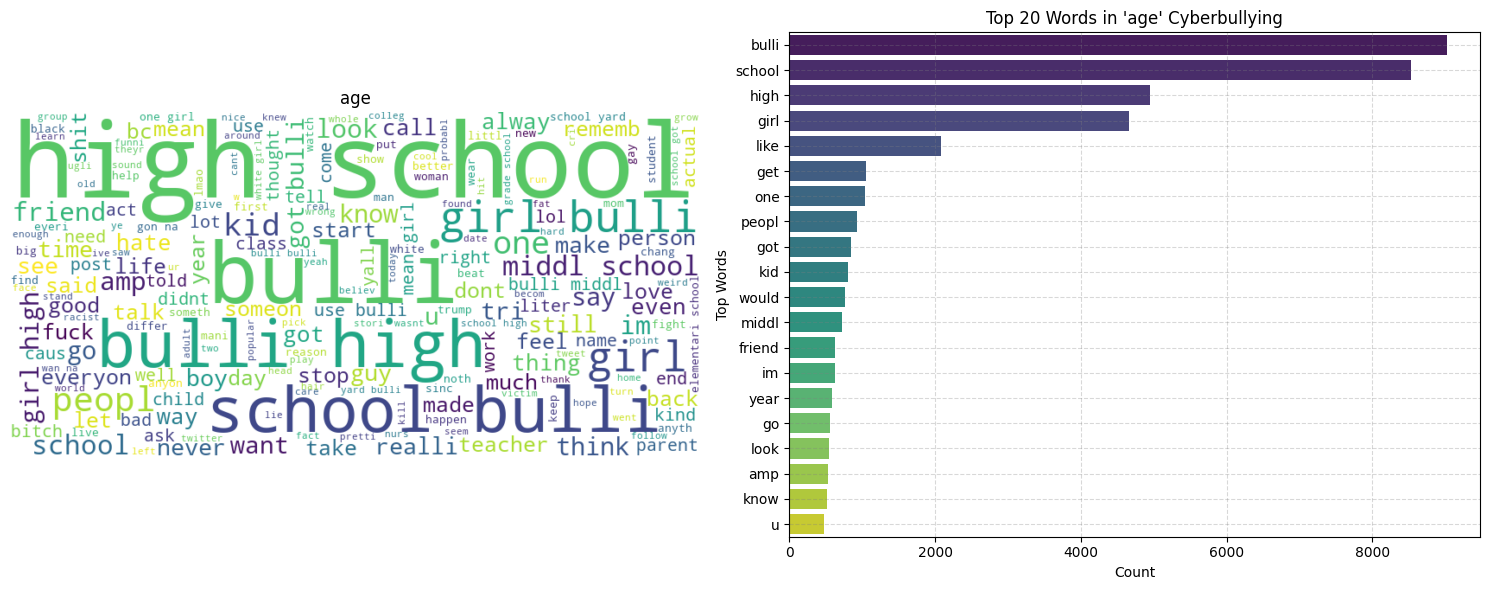

In [39]:
analyse_sentiment_category('age', tweets_df)